In [10]:
# Cell 1 (Updated to use a specific GPU)

import os
import zipfile
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import cv2
import random

# ======================================================================
# 关键修改：在这里强制指定使用 3 号 GPU
# ======================================================================
GPU_ID_TO_USE = 3 
# 设置 CUDA_VISIBLE_DEVICES 环境变量，这是最推荐的方式
# 它会告诉 PyTorch 你的程序只能“看到”3号GPU，并且会把它当作 cuda:0
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_ID_TO_USE)
# ======================================================================

# 设置设备, 现在 torch.device('cuda') 会自动选择我们指定的 GPU
# 如果 CUDA_VISIBLE_DEVICES 生效，这里的 'cuda' 实际上就是指物理上的 GPU 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"Successfully set to use Physical GPU {GPU_ID_TO_USE}.")
    print(f"PyTorch sees it as device: {DEVICE}")
    print(f"Current PyTorch device index: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}") # 注意这里是 get_device_name(0)
else:
    print(f"Using device: {DEVICE}")


# 设置随机种子以保证结果可复现
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

Successfully set to use Physical GPU 3.
PyTorch sees it as device: cuda
Current PyTorch device index: 0
Device name: NVIDIA GeForce RTX 3090


In [11]:
# # Cell 2: 下载并解压数据集
# # MindSpore手册中提供了下载方式，这里我们直接从U-Net原作者官网下载
# def download_and_extract_data():
#     data_dir = 'data/Unet'
#     if os.path.exists(data_dir):
#         print("Dataset already exists.")
#         return
    
#     print("Downloading ISBI dataset...")
#     url = "https://github.com/usatyloe/U-Net-in-PyTorch-for-medical-image-segmentation/releases/download/v1.0/data.zip"
#     os.makedirs(data_dir, exist_ok=True)
#     zip_path = os.path.join(data_dir, 'data.zip')
# download_and_extract_data()

Image data shape: (30, 512, 512)
Label data shape: (30, 512, 512)


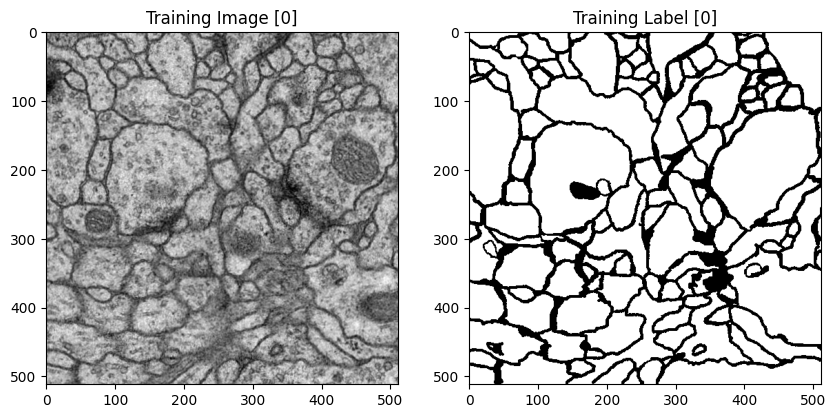

In [12]:
# Cell 3 (Updated): 加载并可视化数据
# 数据集格式是.tif, 我们用Pillow来读取
def load_multipage_tiff(path):
    """从多页TIF文件中加载所有图像到一个numpy数组中"""
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found at {path}")
    return np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(path))])

# 定义新的数据路径
DATA_PATH_PREFIX = 'data/Unet/'
TRAIN_IMG_PATH = os.path.join(DATA_PATH_PREFIX, 'train-volume.tif')
TRAIN_LBL_PATH = os.path.join(DATA_PATH_PREFIX, 'train-labels.tif')
TEST_IMG_PATH = os.path.join(DATA_PATH_PREFIX, 'test-volume.tif') # 这是测试图像，我们稍后会用到

try:
    train_images = load_multipage_tiff(TRAIN_IMG_PATH)
    train_labels = load_multipage_tiff(TRAIN_LBL_PATH)

    print("Image data shape:", train_images.shape)
    print("Label data shape:", train_labels.shape)

    # 可视化第一张图像和标签
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Training Image [0]")
    plt.imshow(train_images[0], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Training Label [0]")
    plt.imshow(train_labels[0], cmap='gray')
    plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the dataset files exist at the specified paths:")
    print(f"  - {TRAIN_IMG_PATH}")
    print(f"  - {TRAIN_LBL_PATH}")

--- Answering Question 1 ---


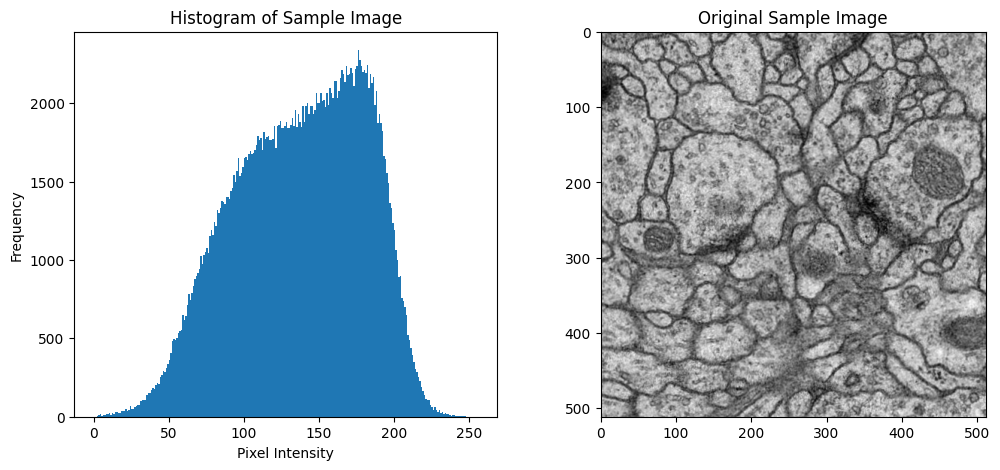


--- Answering Question 2 ---
Otsu's method determined threshold: 133.0


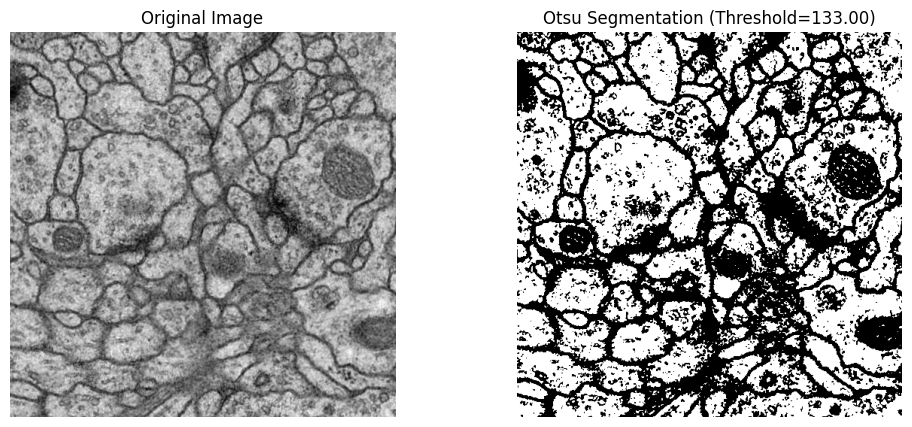

观察结果: 大津法对于这种细胞边界模糊、内部结构复杂的图像效果不佳，产生了大量噪点和粘连。


In [13]:
# Cell 4: 试题 1 & 2 - 使用OpenCV实现大津阈值法
# ----------------------------------------------------------------
# 试题 1: 请用 OpenCV 和 matplotlib 取出一张训练集中的图像，并绘制图像直方图。(初级)
# 解答 1:
print("--- Answering Question 1 ---")
# 使用第一张训练图像
sample_image = train_images[0]

plt.figure(figsize=(12, 5))

# 绘制直方图
plt.subplot(1, 2, 1)
plt.hist(sample_image.ravel(), bins=256, range=[0, 256])
plt.title("Histogram of Sample Image")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# 显示原始图像
plt.subplot(1, 2, 2)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Sample Image")
plt.show()

# ----------------------------------------------------------------
# 试题 2: 请用 OpenCV 中的 python 接口实现基于大津阈值法的图像二值化分割。(初级)
# 解答 2:
print("\n--- Answering Question 2 ---")
# 使用 cv2.threshold 进行大津阈值法分割
# cv2.THRESH_OTSU 会自动计算最佳阈值
ret_val, otsu_thresholded = cv2.threshold(sample_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print(f"Otsu's method determined threshold: {ret_val}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(otsu_thresholded, cmap='gray')
plt.title(f"Otsu Segmentation (Threshold={ret_val:.2f})")
plt.axis('off')
plt.show()

print("观察结果: 大津法对于这种细胞边界模糊、内部结构复杂的图像效果不佳，产生了大量噪点和粘连。")

In [ ]:
# Cell 5: 构建 U-Net 的基本模块
class DoubleConv(nn.Module):
    """(Convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        # U-Net原文使用'valid' padding, 会导致特征图尺寸减小
        # 现代实现通常使用'same' padding (padding=1 for kernel_size=3)来保持尺寸
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # 如果 bilinear, 使用双线性插值进行上采样
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # 否则使用转置卷积
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # 拼接(Concatenate)来自编码器的特征图 (skip connection)
        # x2 是编码器路径的特征图, x1 是上采样后的特征图
        # 需要处理尺寸不匹配的问题 (如果未使用'same' padding)
        # 这里我们假设使用'same' padding, 尺寸是匹配的
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = TF.pad(x1, [diffX // 2, diffX - diffX // 2,diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
# Cell 6: 试题 3 - 搭建完整的 U-Net 网络
# ----------------------------------------------------------------
# 试题 3: 使用 MindSpore 搭建 Unet 类,用于构建网络。要求:网络结构和原论文保持一致。
# 解答 3: 我们用PyTorch实现与原论文结构一致的U-Net
# 注意: 现代实现通常使用'same' padding, 这里我们为了教学目的，也采用这种方式。
# 并且，我们将使用双线性插值作为上采样默认方式。

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        # Encoder (下采样路径)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        # Decoder (上采样路径)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        # Output layer
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # Final output
        logits = self.outc(x)
        return logits

# 实例化并打印模型结构
model = UNet(n_channels=1, n_classes=2) # 输入是1通道灰度图, 输出是2类(背景, 细胞)
print("--- Answering Question 3 ---")
print("U-Net model structure:")
print(model)

--- Answering Question 3 ---
U-Net model structure:
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=

In [16]:
# Cell 7: 试题 4 & 5 - 定义损失函数和Dice系数
# ----------------------------------------------------------------
# 试题 4: 请重新构建一个类,将...nn.SoftmaxCrossEntropyWithLogits 损失函数用于 Unet...
# 解答 4: PyTorch中, nn.CrossEntropyLoss 已经包含了Softmax和计算交叉熵的功能。
# 它可以直接处理模型的原始输出(logits)。对于分割任务，它会计算每个像素的损失。
print("--- Answering Question 4 ---")
# 对于二分类问题，并且输出通道为2, nn.CrossEntropyLoss 是一个很好的选择。
# 另一种选择是 nn.BCEWithLogitsLoss (二元交叉熵), 这需要输出通道为1。
# 这里我们遵循多分类的思路，使用 nn.CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
print(f"Loss function for U-Net: {criterion}")

# ----------------------------------------------------------------
# 试题 5: 定义一个名为 dice_coeff 的类,用于计算...Dice 以及返回...Dice 的均值。
# 解答 5: 我们定义一个函数来计算Dice系数，然后在验证循环中调用它并求平均。
print("\n--- Answering Question 5 ---")
def dice_coeff_func(pred, target, smooth=1e-6):
    """计算Dice系数的函数"""
    # pred: 模型的softmax输出 [B, C, H, W]
    # target: 真实标签 [B, H, W]
    
    # 将pred转换为类别索引
    pred = pred.argmax(dim=1)
    
    # 将target转换为one-hot编码
    target_one_hot = torch.nn.functional.one_hot(target, num_classes=2).permute(0, 3, 1, 2)
    pred_one_hot = torch.nn.functional.one_hot(pred, num_classes=2).permute(0, 3, 1, 2)
    
    # 忽略背景类 (类别0), 只计算前景类 (类别1) 的Dice
    intersection = (pred_one_hot[:, 1] * target_one_hot[:, 1]).sum()
    union = pred_one_hot[:, 1].sum() + target_one_hot[:, 1].sum()
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

print("Dice coefficient function defined.")
# 我们可以创建一个简单的类来包装这个功能，以满足题目要求
class DiceMetric:
    def __init__(self):
        self.reset()

    def update(self, pred, target):
        dice = dice_coeff_func(pred, target)
        self.dice_sum += dice.item()
        self.num_samples += 1

    def compute(self):
        if self.num_samples == 0:
            return 0
        return self.dice_sum / self.num_samples
    
    def reset(self):
        self.dice_sum = 0
        self.num_samples = 0

dice_metric = DiceMetric()
print("DiceMetric class defined.")

--- Answering Question 4 ---
Loss function for U-Net: CrossEntropyLoss()

--- Answering Question 5 ---
Dice coefficient function defined.
DiceMetric class defined.


In [17]:
# Cell 8: 创建自定义数据集类
class ISBI_Dataset(Dataset):
    def __init__(self, images, labels, augment=False):
        self.images = images
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.labels[idx]

        # 转换为PIL Image以便使用torchvision的变换
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        # 数据增强
        if self.augment:
            # 随机旋转
            if random.random() > 0.5:
                angle = random.randint(-30, 30)
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle)
            
            # 随机水平翻转
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.vflip(mask)
            
            # 随机垂直翻转
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)

        # 转换为Tensor
        image = TF.to_tensor(image)
        
        # 将mask转换为Tensor, 注意标签的值范围
        mask = torch.from_numpy(np.array(mask)).long()
        # 将标签中的255(前景)转换为1
        mask[mask == 255] = 1

        return image, mask

# 划分训练集和验证集 (30张图片，用24张训练，6张验证)
train_dataset = ISBI_Dataset(train_images[:24], train_labels[:24], augment=True)
val_dataset = ISBI_Dataset(train_images[24:], train_labels[24:], augment=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 24
Validation dataset size: 6


In [18]:
# Cell 9: 训练和验证循环
model = UNet(n_channels=1, n_classes=2).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 25

print("\n--- Starting Training ---")
for epoch in range(epochs):
    # 训练
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # 验证
    model.eval()
    val_dice = DiceMetric()
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            val_dice.update(outputs, masks)
            
    avg_train_loss = epoch_loss / len(train_loader)
    avg_val_dice = val_dice.compute()
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Dice: {avg_val_dice:.4f}")


--- Starting Training ---
Epoch 1/25 | Train Loss: 0.6605 | Val Dice: 0.0000


Epoch 2/25 | Train Loss: 0.5490 | Val Dice: 0.8683
Epoch 3/25 | Train Loss: 0.5652 | Val Dice: 0.8910
Epoch 4/25 | Train Loss: 0.5242 | Val Dice: 0.8914
Epoch 5/25 | Train Loss: 0.4881 | Val Dice: 0.8910
Epoch 6/25 | Train Loss: 0.4697 | Val Dice: 0.8911
Epoch 7/25 | Train Loss: 0.4989 | Val Dice: 0.8926
Epoch 8/25 | Train Loss: 0.5229 | Val Dice: 0.8956
Epoch 9/25 | Train Loss: 0.4769 | Val Dice: 0.9063
Epoch 10/25 | Train Loss: 0.4806 | Val Dice: 0.9215
Epoch 11/25 | Train Loss: 0.5381 | Val Dice: 0.9224
Epoch 12/25 | Train Loss: 0.4907 | Val Dice: 0.9259
Epoch 13/25 | Train Loss: 0.4660 | Val Dice: 0.9096
Epoch 14/25 | Train Loss: 0.5186 | Val Dice: 0.9252
Epoch 15/25 | Train Loss: 0.4682 | Val Dice: 0.9286
Epoch 16/25 | Train Loss: 0.4593 | Val Dice: 0.9276
Epoch 17/25 | Train Loss: 0.4954 | Val Dice: 0.9228
Epoch 18/25 | Train Loss: 0.4682 | Val Dice: 0.9057
Epoch 19/25 | Train Loss: 0.4868 | Val Dice: 0.9227
Epoch 20/25 | Train Loss: 0.4707 | Val Dice: 0.9276
Epoch 21/25 | Train 


--- Answering Question 6: Visualizing Predictions ---


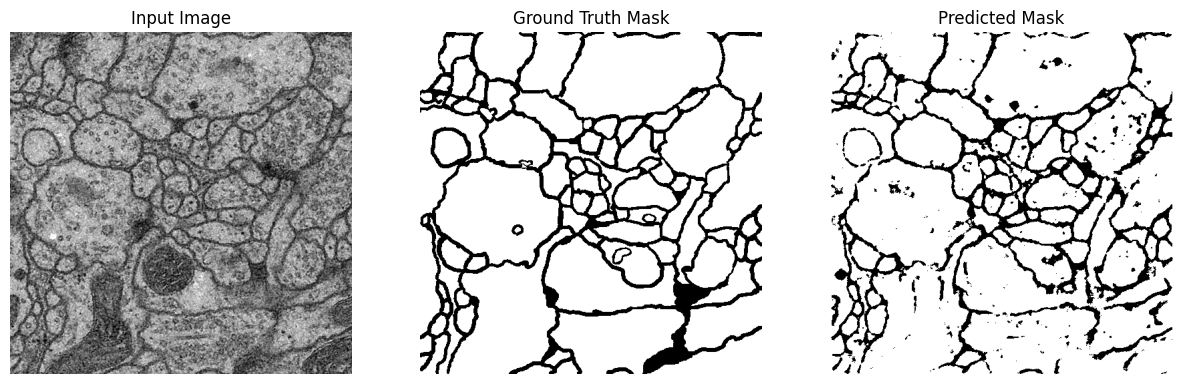

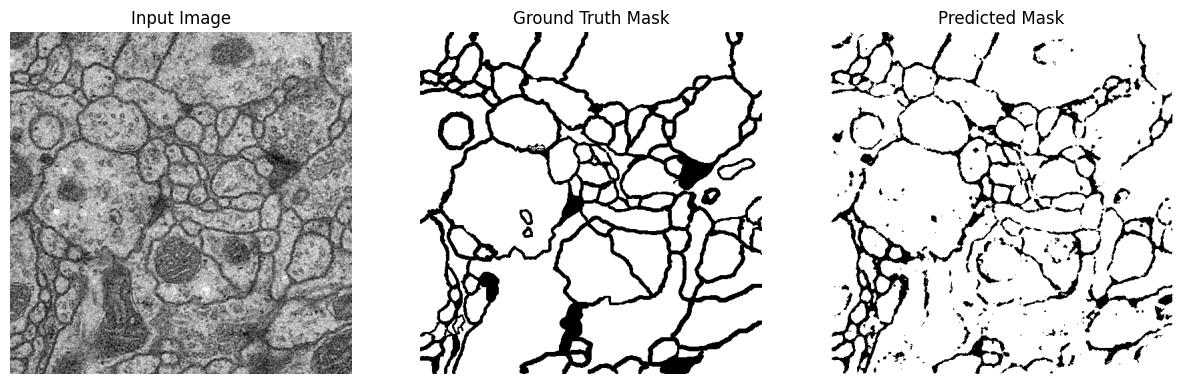

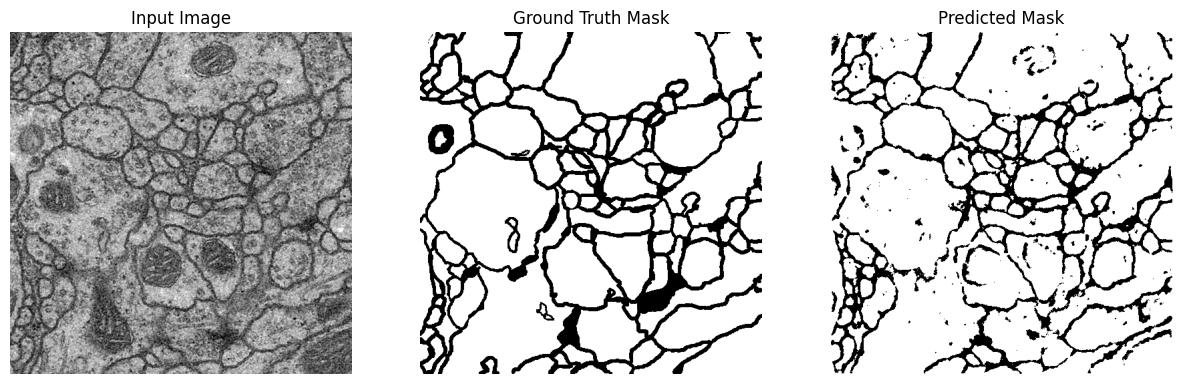

In [19]:
# Cell 10: 试题 6 - 可视化预测结果
# ----------------------------------------------------------------
# 试题 6: 请在 test_net 原函数基础上调用测试数据集进行预测,并可视化预测结果...
# 解答 6: 我们将使用验证集的前几张图片进行预测和可视化。
# 注意: U-Net原文输入输出尺寸不同，需要对输入进行padding。我们的实现使用了'same'卷积，
# 输入输出尺寸相同，因此不需要手册中的复杂预处理。

print("\n--- Answering Question 6: Visualizing Predictions ---")
model.eval()
with torch.no_grad():
    # 取验证集前3张图
    for i in range(min(3, len(val_dataset))):
        image, mask = val_dataset[i]
        image_gpu = image.unsqueeze(0).to(DEVICE) # 添加batch维度并送到GPU

        output = model(image_gpu)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(image.squeeze().numpy(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask.numpy(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')
        
        plt.show()

Loaded test dataset with shape: (30, 512, 512)


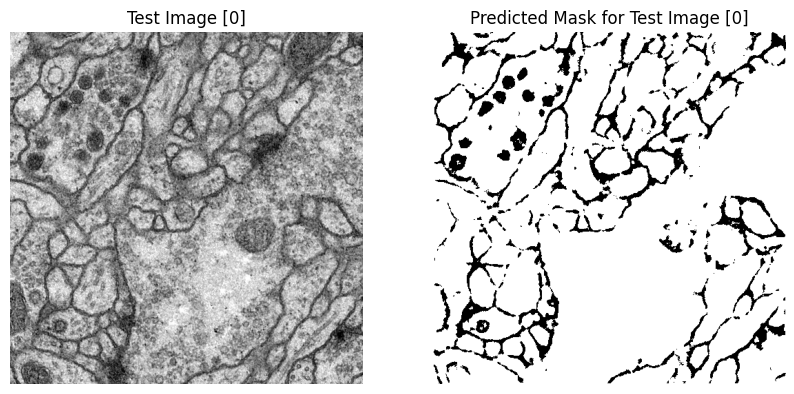

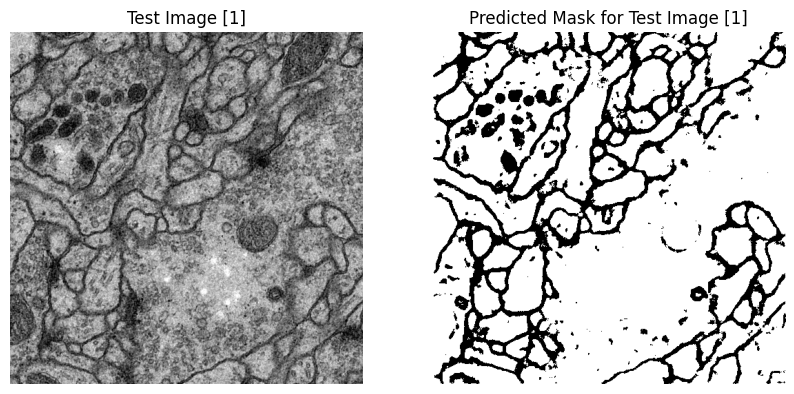

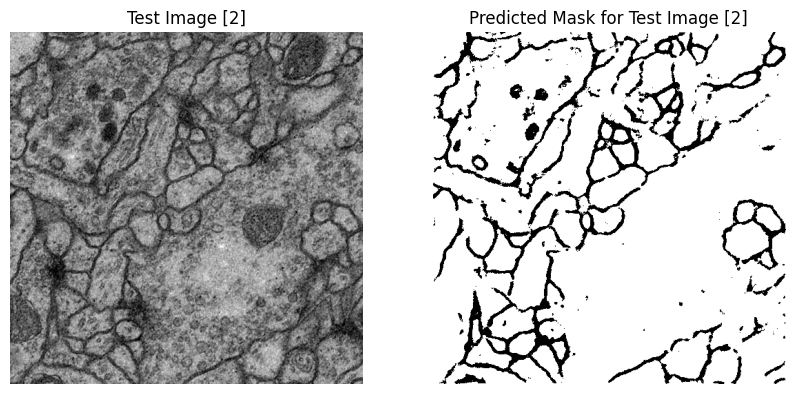

In [20]:
# Cell 11: 在测试集上进行预测和可视化
# 加载测试集数据
try:
    test_images = load_multipage_tiff(TEST_IMG_PATH)
    print(f"Loaded test dataset with shape: {test_images.shape}")

    # 对测试集的前几张图片进行预测
    model.eval()
    with torch.no_grad():
        # 取测试集前3张图
        for i in range(min(3, len(test_images))):
            # 预处理测试图像 (转为Tensor, 添加batch和channel维度)
            test_image_np = test_images[i]
            test_image_pil = Image.fromarray(test_image_np)
            test_image_tensor = TF.to_tensor(test_image_pil).unsqueeze(0).to(DEVICE)

            # 模型预测
            output = model(test_image_tensor)
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

            # 可视化
            plt.figure(figsize=(10, 5))
            
            plt.subplot(1, 2, 1)
            plt.title(f"Test Image [{i}]")
            plt.imshow(test_image_np, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.title(f"Predicted Mask for Test Image [{i}]")
            plt.imshow(pred_mask, cmap='gray')
            plt.axis('off')
            
            plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
    print(f"Could not load the test set. Please check the path: {TEST_IMG_PATH}")